# Download data

In [30]:
import pandas as pd
import requests
import io
import time

# Load the Excel file
file_path = "input_datasheet.xlsx"
sheet_name = "datasheet"
df = pd.read_excel(file_path, sheet_name=sheet_name)

# Setup sessions for APIs
pvgis_session = requests.Session()
rn_session = requests.Session()
rn_token = 'bc82ea6654e50592c62c10a19de0d02b6cb0e333' #Paste your Renewables.ninja token here
rn_session.headers = {'Authorization': 'Token ' + rn_token}

# Databases for each API
pvgis_databases = ['PVGIS-SARAH2', 'PVGIS-ERA5']
rn_databases = ['merra2', 'sarah']

# Dictionary to store production data for each installation, database, and year
productions = {}

# Function to generate date ranges
def generate_date_ranges(start_year, end_year):
    return [(f"{year}-01-01", f"{year}-12-31") for year in range(start_year, end_year + 1)]

# Function to create URL for PVGIS
def create_pvgis_url(row, db, year):
    return (
        f"https://re.jrc.ec.europa.eu/api/v5_2/seriescalc?"
        f"lat={row['latitude']}&lon={row['longitude']}&aspect={row['azimuth'] - 180}&angle={row['tilt']}"
        f"&pvcalculation=1&peakpower={int(row['peakpower_kW'])}.0&loss={row['loss']}&pvtechchoice={row['pv_technology']}"
        f"&startyear={year}&endyear={year}&outputformat=csv"
        f"&mountingplace={row['building/free']}&browser=1&raddatabase={db}"
    )

# Iterate over the dataframe to get production data for each installation
for index, row in df.iterrows():
    # PVGIS Data Retrieval
    for db in pvgis_databases:
        for year in range(int(row['startyear']), int(row['endyear']) + 1):
            api_url = create_pvgis_url(row, db, year)
            identifier = f"{row['cod']}{year}_PG-{db.split('-')[1]}"  # Append year here
            try:
                response = pvgis_session.get(api_url)
                if response.status_code == 200:
                    data = pd.read_csv(io.StringIO(response.text), skiprows=10)
                    data = data[:-7]  # Assuming data format requires removing the last 7 rows
                    productions.setdefault(identifier, []).extend((data["P"].astype(float)/1000).values)
                else:
                    print(f"Data not available in PVGIS for {identifier}")
            except Exception as e:
                print(f"Error retrieving PVGIS data for {identifier}: {e}")

    # Renewable Ninja Data Retrieval
    for db in rn_databases:
        for date_from, date_to in generate_date_ranges(int(row['startyear']), int(row['endyear'])):
            year = date_from[:4]
            identifier = f"{row['cod']}{year}_RN-{db.upper()}"
            args = {
                'lat': row['latitude'],
                'lon': row['longitude'],
                'date_from': date_from,
                'date_to': date_to,
                'dataset': db,
                'capacity': row['peakpower_kW'],
                'system_loss': row['loss'] / 100,
                'tracking': 0 if row['fixed'] == 1 else row['tracking'],
                'tilt': row['tilt'],
                'azim': row['azimuth'],
                'format': 'csv'
            }
            while True:
                response = rn_session.get(f"https://www.renewables.ninja/api/data/pv", params=args)
                if response.status_code == 200:
                    data = pd.read_csv(io.StringIO(response.text), skiprows=3)
                    productions.setdefault(identifier, []).extend(data['electricity'].astype(float).values)
                    break
                elif response.status_code == 429:
                    retry_after = int(response.headers.get('Retry-After', 3600))
                    print(f"Rate limit hit for Renewable Ninja. Pausing for {retry_after} seconds.")
                    time.sleep(retry_after)
                else:
                    print(f"Data not available in Renewable Ninja data for {identifier}: {response.text}")
                    break

# Convert all lists to pandas Series and create a DataFrame
for key, value in productions.items():
    productions[key] = pd.Series(value)
output_df = pd.DataFrame(productions)
output_df.index += 1 #Start first line at 1 instead of 0

# Desired order for databases
database_order = ['RN-MERRA2', 'RN-SARAH', 'PG-SARAH', 'PG-SARAH2', 'PG-ERA5']

# Function to extract sort keys from column names
def sort_key(col):
    location_year, db = col.split('_', 1)  # Split at the first underscore
    year = location_year[-4:]  # Extract the year (last four characters)
    location = location_year[:-4]  # Extract location (all but last four characters)
    db_key = db.split('-')[1] if '-' in db else db  # Normalize the db part for sorting
    db_index = database_order.index(db_key) if db_key in database_order else len(database_order)
    return (location, year, db_index)

# Sort columns based on custom key
sorted_columns = sorted(output_df.columns, key=sort_key)

# Reorder DataFrame according to sorted columns
output_df = output_df[sorted_columns]

# Generate new column headers based on the sorted columns
new_columns = []
index_counter = 1
for col in sorted_columns:
    location_year, db = col.split('_', 1)
    new_columns.append(("Solar fixed", location_year, f"PG-{db.split('-')[1]}", "RPU_Solar_fixed", str(index_counter)))
    index_counter += 1

# Create a MultiIndex
multi_index = pd.MultiIndex.from_tuples(new_columns, names=["", "Locations", "Profile time series", "Subsets", "Index"])

# Assign this MultiIndex to the DataFrame
output_df.columns = multi_index

# Save the DataFrame to an Excel file
output_file = "PV_DATA_meas_sim.csv"
output_df.to_csv(output_file)  # Make sure to set index=False if not using DataFrame index

print("Simulated PV data excel sheet successfully generated!")

Data not available in Renewable Ninja data for Torino2019_RN-SARAH: Error: 
date_to must be 2015-12-31 or earlier
Rate limit hit for Renewable Ninja. Pausing for 1 seconds.
Data not available in Renewable Ninja data for Torino2020_RN-SARAH: Error: 
date_to must be 2015-12-31 or earlier
Data not available in Renewable Ninja data for Utrecht2016_RN-SARAH: Error: 
date_to must be 2015-12-31 or earlier
Rate limit hit for Renewable Ninja. Pausing for 1 seconds.
Data not available in Renewable Ninja data for Utrecht2017_RN-SARAH: Error: 
date_to must be 2015-12-31 or earlier
Data not available in PVGIS for Almeria2023_PG-SARAH2
Data not available in PVGIS for Almeria2023_PG-ERA5
Data not available in Renewable Ninja data for Almeria2023_RN-SARAH: Error: 
date_to must be 2015-12-31 or earlier
Simulated PV data excel sheet successfully generated!


In [ ]:
import pandas as pd
import requests
import io
import time

# Load the Excel file
file_path = "input_datasheet.xlsx"
sheet_name = "datasheet"
df = pd.read_excel(file_path, sheet_name=sheet_name)

# Setup sessions for APIs
pvgis_session = requests.Session()
rn_session = requests.Session()
rn_token = 'b1c4fdb0061a9b31fe363bccaba98201f311e055'
rn_session.headers = {'Authorization': 'Token ' + rn_token}

# Databases for each API
pvgis_databases = ['PVGIS-SARAH2', 'PVGIS-ERA5']
rn_databases = ['merra2', 'sarah']

# Dictionary to store production data for each installation, database, and year
productions = {}

# Function to generate date ranges
def generate_date_ranges(start_year, end_year):
    return [(f"{year}-01-01", f"{year}-12-31") for year in range(start_year, end_year + 1)]

# Function to create URL for PVGIS
def create_pvgis_url(row, db, year):
    return (
        f"https://re.jrc.ec.europa.eu/api/v5_2/seriescalc?"
        f"lat={row['latitude']}&lon={row['longitude']}&aspect={row['azimuth'] - 180}&angle={row['tilt']}"
        f"&pvcalculation=1&peakpower={int(row['peakpower_kW'])}.0&loss={row['loss']}&pvtechchoice={row['pv_technology']}"
        f"&startyear={year}&endyear={year}&outputformat=csv"
        f"&mountingplace={row['building/free']}&browser=1&raddatabase={db}"
    )

# Iterate over the dataframe to get production data for each installation in kWh
for index, row in df.iterrows():
    # PVGIS Data Retrieval
    for db in pvgis_databases:
        for year in range(int(row['startyear']), int(row['endyear']) + 1):
            api_url = create_pvgis_url(row, db, year)
            identifier = f"{row['cod']}{year}_PG-{db.split('-')[1]}"  # Append year here
            try:
                response = pvgis_session.get(api_url)
                if response.status_code == 200:
                    data = pd.read_csv(io.StringIO(response.text), skiprows=10)
                    data = data[:-7]  # Assuming data format requires removing the last 7 rows
                    productions.setdefault(identifier, []).extend((data["P"].astype(float)/1000).values)
                else:
                    print(f"Failed to retrieve data for {identifier}")
            except Exception as e:
                print(f"Error retrieving PVGIS data for {identifier}: {e}")

    # Renewable Ninja Data Retrieval
    for db in rn_databases:
        for date_from, date_to in generate_date_ranges(int(row['startyear']), int(row['endyear'])):
            year = date_from[:4]
            identifier = f"{row['cod']}{year}_RN-{db.upper()}"
            args = {
                'lat': row['latitude'],
                'lon': row['longitude'],
                'date_from': date_from,
                'date_to': date_to,
                'dataset': db,
                'capacity': row['peakpower_kW'],
                'system_loss': row['loss'] / 100,
                'tracking': 0 if row['fixed'] == 1 else row['tracking'],
                'tilt': row['tilt'],
                'azim': row['azimuth'],
                'format': 'csv'
            }
            while True:
                response = rn_session.get(f"https://www.renewables.ninja/api/data/pv", params=args)
                if response.status_code == 200:
                    data = pd.read_csv(io.StringIO(response.text), skiprows=3)
                    productions.setdefault(identifier, []).extend(data['electricity'].astype(float).values)
                    break
                elif response.status_code == 429:
                    retry_after = int(response.headers.get('Retry-After', 3600))
                    print(f"Rate limit hit for Renewable Ninja. Pausing for {retry_after} seconds.")
                    time.sleep(retry_after)
                else:
                    print(f"Failed to download Renewable Ninja data for {identifier}: {response.text}")
                    break

# Convert all lists to pandas Series and create a DataFrame
for key, value in productions.items():
    productions[key] = pd.Series(value)
output_df = pd.DataFrame(productions)

# Desired order for databases
database_order = ['RN-MERRA2', 'RN-SARAH', 'PG-SARAH', 'PG-SARAH2', 'PG-ERA5']

# Function to extract sort keys from column names
def sort_key(col):
    location_year, db = col.split('_', 1)  # Split at the first underscore
    year = location_year[-4:]  # Extract the year (last four characters)
    location = location_year[:-4]  # Extract location (all but last four characters)
    db_key = db.split('-')[1] if '-' in db else db  # Normalize the db part for sorting
    db_index = database_order.index(db_key) if db_key in database_order else len(database_order)
    return (location, year, db_index)

# Sort columns based on custom key
sorted_columns = sorted(output_df.columns, key=sort_key)

# Reorder DataFrame according to sorted columns
output_df = output_df[sorted_columns]

# Generate new column headers based on the sorted columns
new_columns = []
index_counter = 1
for col in sorted_columns:
    location_year, db = col.split('_', 1)
    new_columns.append(("Solar fixed", location_year, f"PG-{db.split('-')[1]}", "RPU_Solar_fixed", str(index_counter)))
    index_counter += 1

# Create a MultiIndex
multi_index = pd.MultiIndex.from_tuples(new_columns, names=["", "Locations", "Profile time series", "Subsets", "Index"])

# Assign this MultiIndex to the DataFrame
output_df.columns = multi_index

# Save the DataFrame to an Excel file
output_file = "Consolidated_Hourly_Production.xlsx"
output_df.to_excel(output_file, index=True)  # Make sure to set index=False if not using DataFrame index

print("Consolidated Excel sheet successfully generated!")

# Capacity factor cumulated

Locations: ['Forlì2014', 'Utrecht2014', 'Utrecht2015', 'Utrecht2016', 'Utrecht2017', 'Torino2019', 'Torino2020', 'Almería2023']


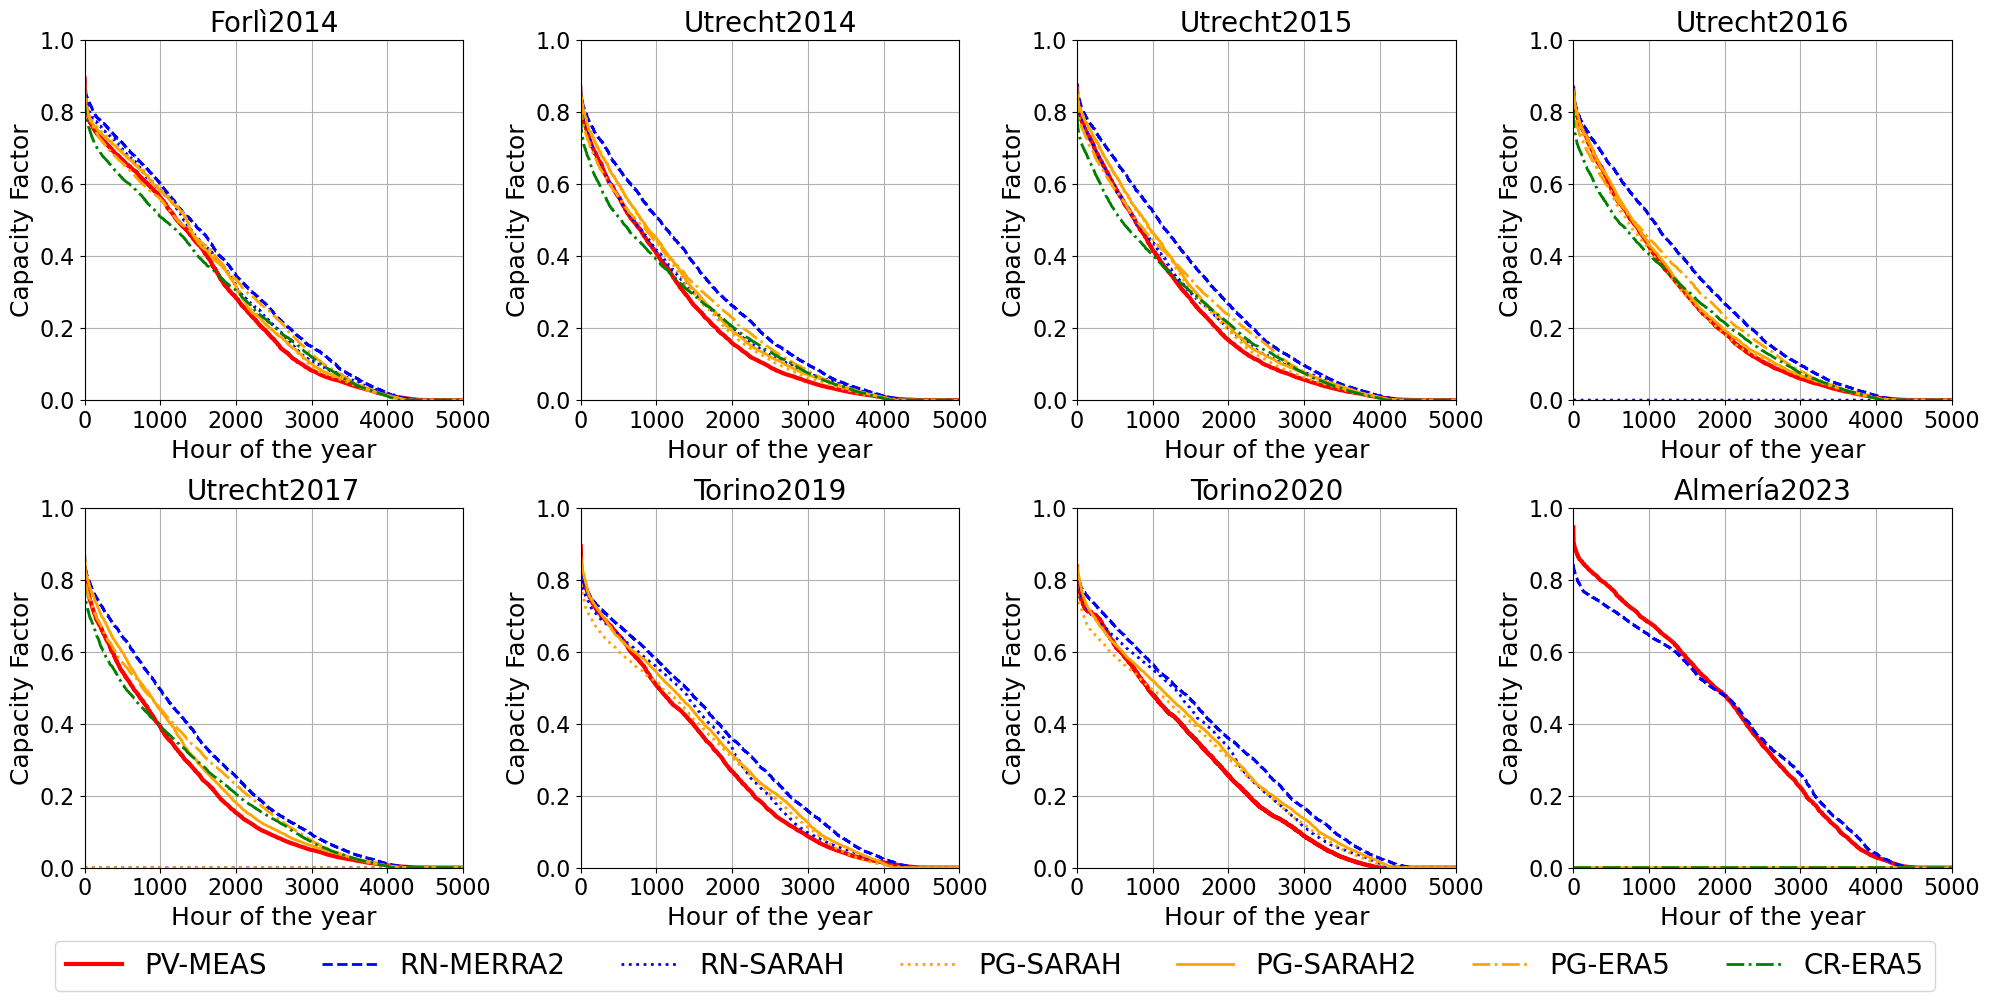

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math

# Load the data from the Excel file
file_path = 'PV_DATA_meas_sim.xlsx'

# Load the data from the Excel file including all columns initially
data = pd.read_excel(file_path, header=None).iloc[:, 1:]

# Drop specific rows: 1st, 4th, and 5th rows (0-based indices: 0, 3, 4)
data = data.drop(index=[0, 3, 4])

# Now set the first two remaining rows as headers
new_header = data.iloc[0:2]  # Take the first two rows for the header
data = data[2:]  # Take the data less the header rows
data.columns = pd.MultiIndex.from_tuples(tuple(zip(new_header.iloc[0], new_header.iloc[1])))


# Extract unique locations from the first level of the MultiIndex
locations = data.columns.get_level_values(0).unique().tolist()  # Get unique locations
print(f"Locations: {locations}")

# Calculate the number of columns needed based on the number of locations
n_locations = len(locations)
n_cols = 4
n_rows = math.ceil(n_locations / 4)

# Combine the headers (location and tool) to form a unique column identifier
data.columns = [' '.join(col).strip() for col in data.columns.values]

# Custom settings for the plot (colors, line styles, etc.)
legend_names = ['PV-MEAS', 'RN-MERRA2', 'RN-SARAH', 'PG-SARAH', 'PG-SARAH2', 'PG-ERA5', 'CR-ERA5']
colors = ['red', 'blue', 'blue', 'orange', 'orange', 'orange', 'green']
linestyles = ['-', '--', ':', ':', '-','-.','-.']  # Line styles for each tool
line_widths = [3, 2, 2, 2, 2, 2, 2]  # Line widths for each tool

# Initialize a large figure to hold all subplots
fig, axs = plt.subplots(n_rows, n_cols, figsize=(20, 10))  # Adjust the figure size as necessary
axs = axs.flatten()  # Flatten the 2D array of axes for easier indexing

# Loop through each unique location in their original order and plot data for that location
for i, location in enumerate(locations):
    ax = axs[i]  # Get the current Axes instance
    loc_data = data[[col for col in data.columns if col.startswith(location)]]
    loc_data_sorted = loc_data.apply(lambda x: x.sort_values(ascending=False).reset_index(drop=True))

    for idx, column in enumerate(loc_data_sorted.columns):
        ax.plot(loc_data_sorted[column], label=legend_names[idx], color=colors[idx], 
                linestyle=linestyles[idx], linewidth=line_widths[idx])

    ax.set_title(f'{location}', fontsize=20)
    ax.set_xlabel('Hour of the year', fontsize=18)
    ax.set_ylabel('Capacity Factor', fontsize=18)
    ax.tick_params(axis='both', which='major', labelsize=16)
    ax.grid(True)
    ax.set_ylim(0, 1)  # Assuming capacity factor ranges from 0 to 1
    ax.set_xlim(0, 5000)

# Handle any extra subplots
for j in range(i + 1, n_rows * n_cols):
    fig.delaxes(axs[j])

# Adjust layout to prevent overlapping
plt.tight_layout()

handles, labels = axs[0].get_legend_handles_labels()  # Get handles and labels from the first subplot
fig.legend(handles, labels, loc='lower center', ncol=len(labels), fontsize=20, bbox_to_anchor=(0.5, -0.01))
plt.tight_layout(rect=[0, 0.05, 1, 1])  # Adjust the rectangle in which to fit the subplots

# Save and display the entire figure
plt.savefig('All_Locations_Capacity_Factor.png', bbox_inches='tight')
plt.show()  # Display the figure


# Error analysis

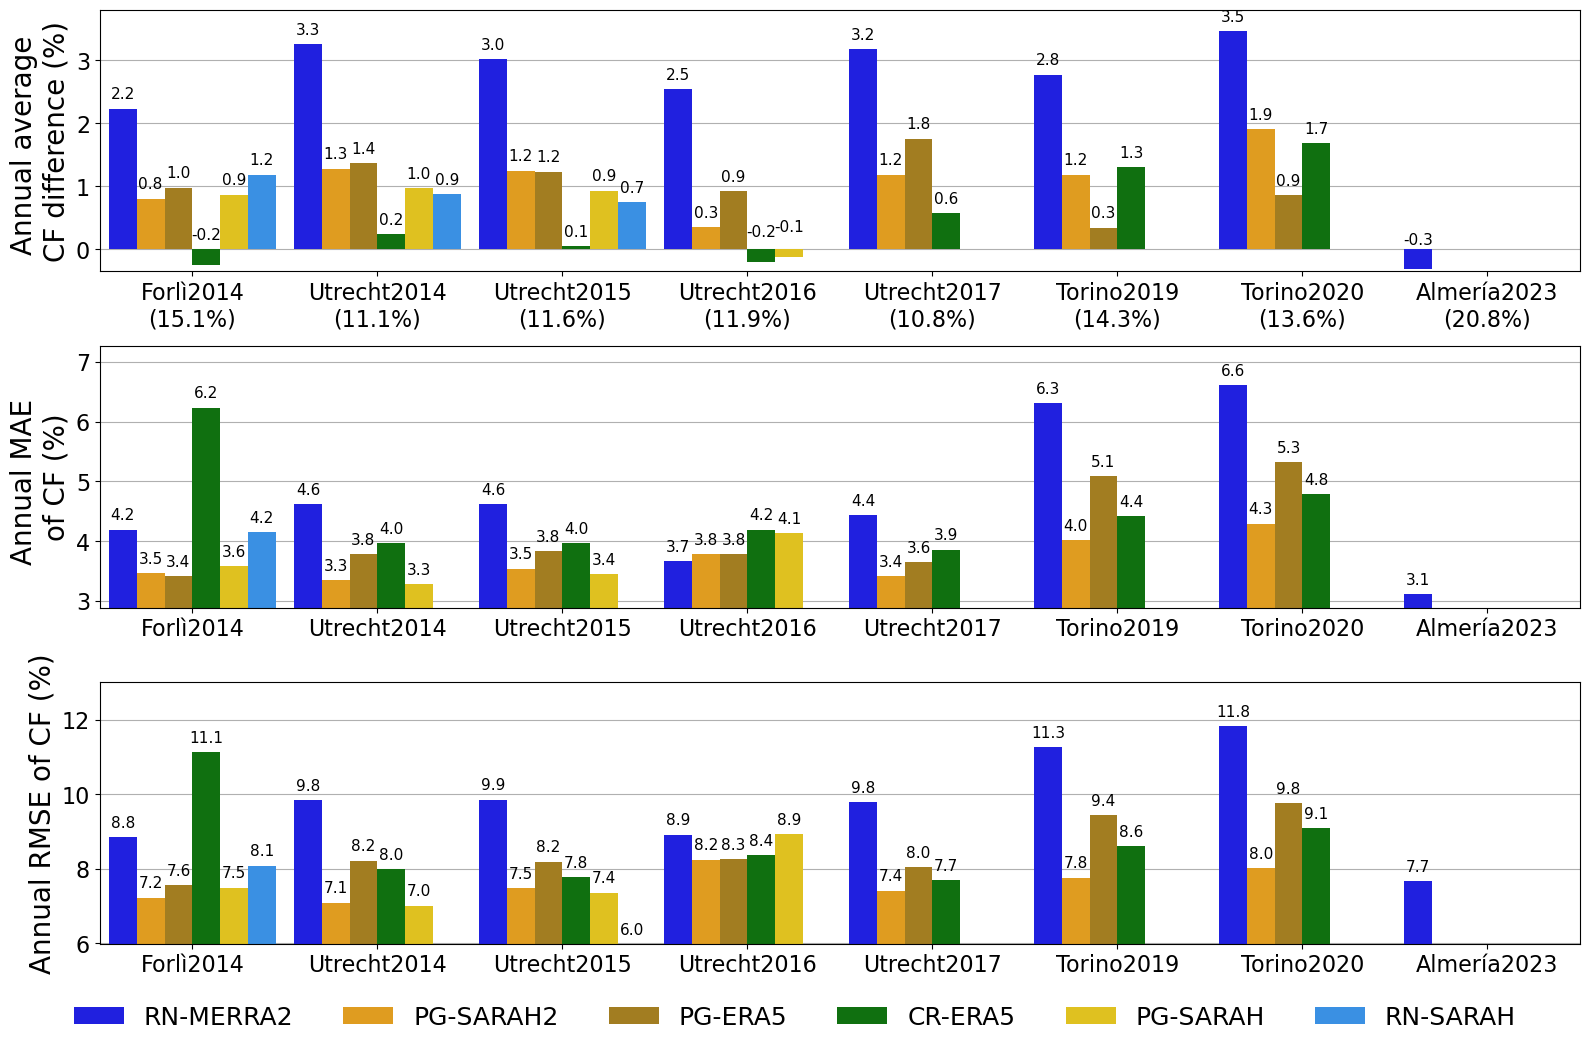

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Load the data from the Excel file
file_path = 'PV_DATA_meas_sim.xlsx'
# Load data without initially setting headers to handle row removal
data = pd.read_excel(file_path, header=None)

# Drop specified rows: original rows 0, 3, and 4
data.drop(index=[0, 3, 4], inplace=True)

# Reset the index after dropping rows to realign the row numbers
data.reset_index(drop=True, inplace=True)

# Set new headers using what are now the first two rows after the drop
new_headers = data.iloc[0:2]  # These are the new header rows
data = data[2:]  # Remove the header rows from the data
data.columns = pd.MultiIndex.from_tuples(tuple(zip(new_headers.iloc[0], new_headers.iloc[1])))

# Assuming you still want to skip the first column of the data
data = data.iloc[:, 1:]

# Now process the data as before
# Define the color palette for the simulation tools
plot_palette = {
    'RN-MERRA2': 'blue',
    'PG-SARAH2': 'orange',
    'PG-ERA5': 'darkgoldenrod',
    'CR-ERA5': 'green',
    'PG-SARAH': 'gold',
    'RN-SARAH': 'dodgerblue',
}

# Process the MultiIndex column names to extract unique locations
locations = []
for col in data.columns:
    location = col[0]  # Access the first element of the tuple, which represents the location
    if location not in locations:
        locations.append(location)

# Initialize results dictionaries for each metric
mean_diff_results = []
mae_results = []
rmse_results = []
mean_diff_labels = []

# Process data for each location
for location in locations:
    loc_data = data[[col for col in data.columns if col[0] == location]]
    loc_data = loc_data.loc[:, (loc_data != 0).any(axis=0)]
    pv_meas_avg = loc_data[(location, 'PV-MEAS')].dropna().mean() * 100

    # Append custom label for the first graph
    mean_diff_labels.append(f"{location}\n({pv_meas_avg:.1f}%)")

    for col in loc_data.columns:
        tool = col[1]
        if tool in plot_palette and tool != 'PV-MEAS':
            valid_data = loc_data[[(location, 'PV-MEAS'), col]].dropna()
            if not valid_data.empty:
                mean_diff = (valid_data[col].mean() - valid_data[(location, 'PV-MEAS')].mean()) * 100
                mean_diff_results.append({'Location': location, 'Tool': tool, 'Mean Difference (%)': mean_diff})
                mae = mean_absolute_error(valid_data[(location, 'PV-MEAS')], valid_data[col]) * 100
                mae_results.append({'Location': location, 'Tool': tool, 'MAE (%)': mae})
                rmse = np.sqrt(mean_squared_error(valid_data[(location, 'PV-MEAS')], valid_data[col])) * 100
                rmse_results.append({'Location': location, 'Tool': tool, 'RMSE (%)': rmse})

# Convert results to DataFrames
mean_diff_df = pd.DataFrame(mean_diff_results)
mae_df = pd.DataFrame(mae_results)
rmse_df = pd.DataFrame(rmse_results)
def add_labels(ax):
    for p in ax.patches:  # Loop through all bars in the subplot
        height = p.get_height()  # Get the height (value) of the bar
        if height >= 0:
            # For positive values, place the label above the bar
            ax.annotate(format(height, '.1f'),  # Format the label to one decimal place
                        (p.get_x() + p.get_width() / 2., height),  # Position at the center of the bar
                        ha='center',  # Center horizontally
                        va='bottom',  # Align to the top of the bar
                        xytext=(0, 5),  # 10 points above the bar
                        textcoords='offset points',  # Use offset for positioning
                        fontsize=11)  # Font size
        else:
            # For negative values, place the label below the bar
            ax.annotate(format(height, '.1f'),  # Format the label to one decimal place
                        (p.get_x() + p.get_width() / 2., height),  # Position at the center of the bar
                        ha='center',  # Center horizontally
                        va='bottom',  # Align to the bottom of the bar
                        xytext=(0, 16),  # 10 points below the bar
                        textcoords='offset points',  # Use offset for positioning
                        fontsize=11)  # Font size
            
# Create a figure with three subplots
fig, axes = plt.subplots(3, 1, figsize=(16, 10))


# Define tick font size
tick_font_size = 16

# Extract the tool order from the palette (ensures tools are plotted in this specific order)
tool_order = list(plot_palette.keys())

# Plot Mean Difference
sns.barplot(x='Location', y='Mean Difference (%)', width=0.9, hue='Tool', data=mean_diff_df, palette=plot_palette, hue_order=tool_order, ax=axes[0])
min_y = mean_diff_df['Mean Difference (%)'].min() * 1.1  # Calculate minimum, extend by 10%
max_y = mean_diff_df['Mean Difference (%)'].max() * 1.1  # Calculate maximum, extend by 10%
axes[0].set_ylim(min_y, max_y)  # Set dynamic y-limits
add_labels(axes[0])  # Call the function to add labels to the bars

axes[0].set_ylabel('Annual average \nCF difference (%)', fontsize=20)
axes[0].set_xticklabels(mean_diff_labels, rotation=0, fontsize=20)
axes[0].tick_params(axis='both', labelsize=tick_font_size)
axes[0].set_axisbelow(True)
axes[0].grid(True, axis='y')
axes[0].set_xlabel('')
axes[0].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: int(x)))
axes[0].get_legend().remove()

# Plot MAE
sns.barplot(x='Location', y='MAE (%)', hue='Tool', width=0.9, data=mae_df, palette=plot_palette, hue_order=tool_order, ax=axes[1])
min_y = mae_df['MAE (%)'].min() * 1.1
max_y = mae_df['MAE (%)'].max() * 1.1
axes[1].set_ylim(min_y, max_y)
add_labels(axes[1])

axes[1].set_ylabel('Annual MAE \nof CF (%)', fontsize=20)
axes[1].tick_params(axis='both', labelsize=tick_font_size)
axes[1].set_axisbelow(True)
axes[1].grid(True, axis='y')
axes[1].set_xlabel('')
axes[1].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: int(x)))
axes[1].get_legend().remove()

# Plot RMSE
sns.barplot(x='Location', y='RMSE (%)', hue='Tool', width=0.9, data=rmse_df, palette=plot_palette, hue_order=tool_order, ax=axes[2])
min_y = rmse_df['RMSE (%)'].min() * 1.1
max_y = rmse_df['RMSE (%)'].max() * 1.1
axes[2].set_ylim(min_y, max_y)
add_labels(axes[2])

axes[2].set_ylabel('Annual RMSE of CF (%)', fontsize=20)
axes[2].tick_params(axis='both', labelsize=tick_font_size)
axes[2].set_axisbelow(True)
axes[2].grid(True, axis='y')
axes[2].set_xlabel('')
axes[2].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: int(x)))
axes[2].get_legend().remove()

# Adjust layout
plt.tight_layout()

# Create one legend for all plots at the bottom
handles, labels = axes[2].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=len(plot_palette), bbox_to_anchor=(0.5, -0.06), fontsize=18, frameon=False)

plt.savefig('Combined_Metrics.with.lables.png', bbox_inches='tight')
plt.show()


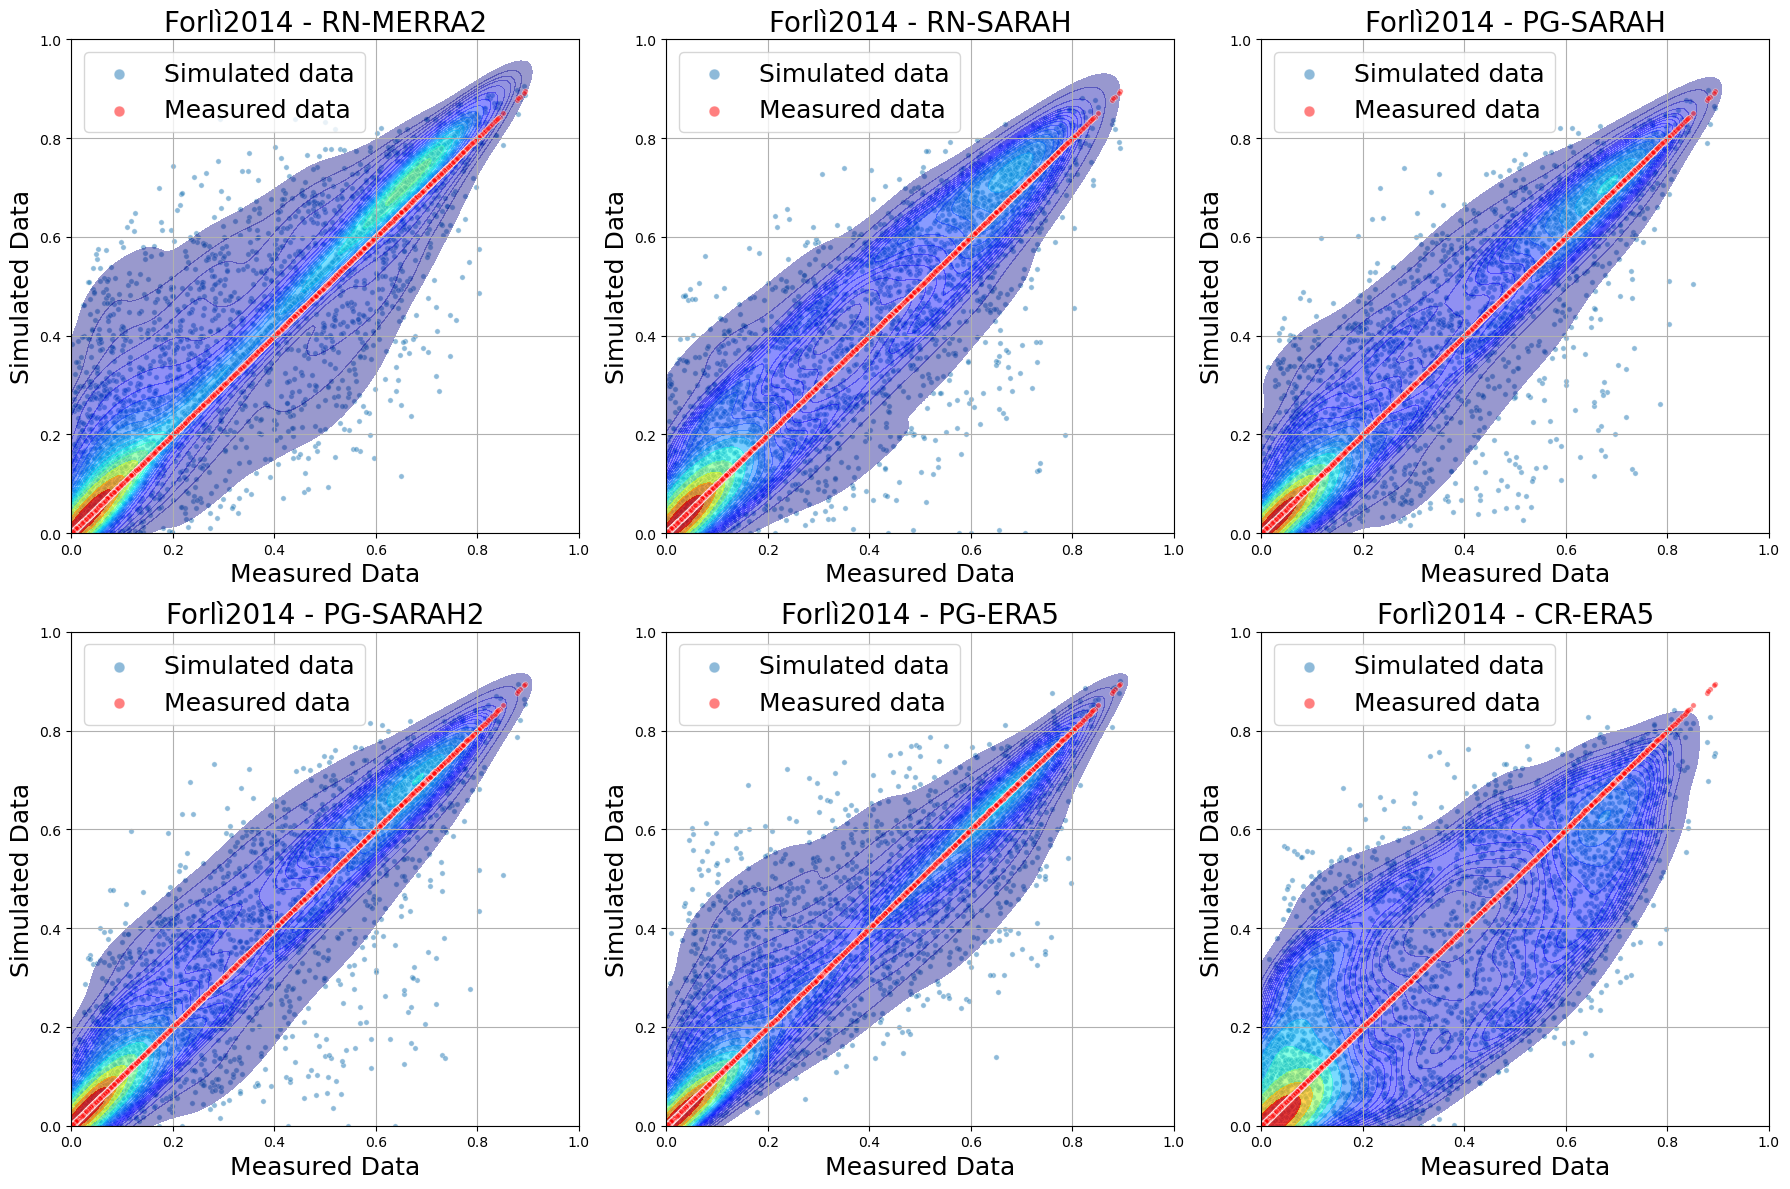

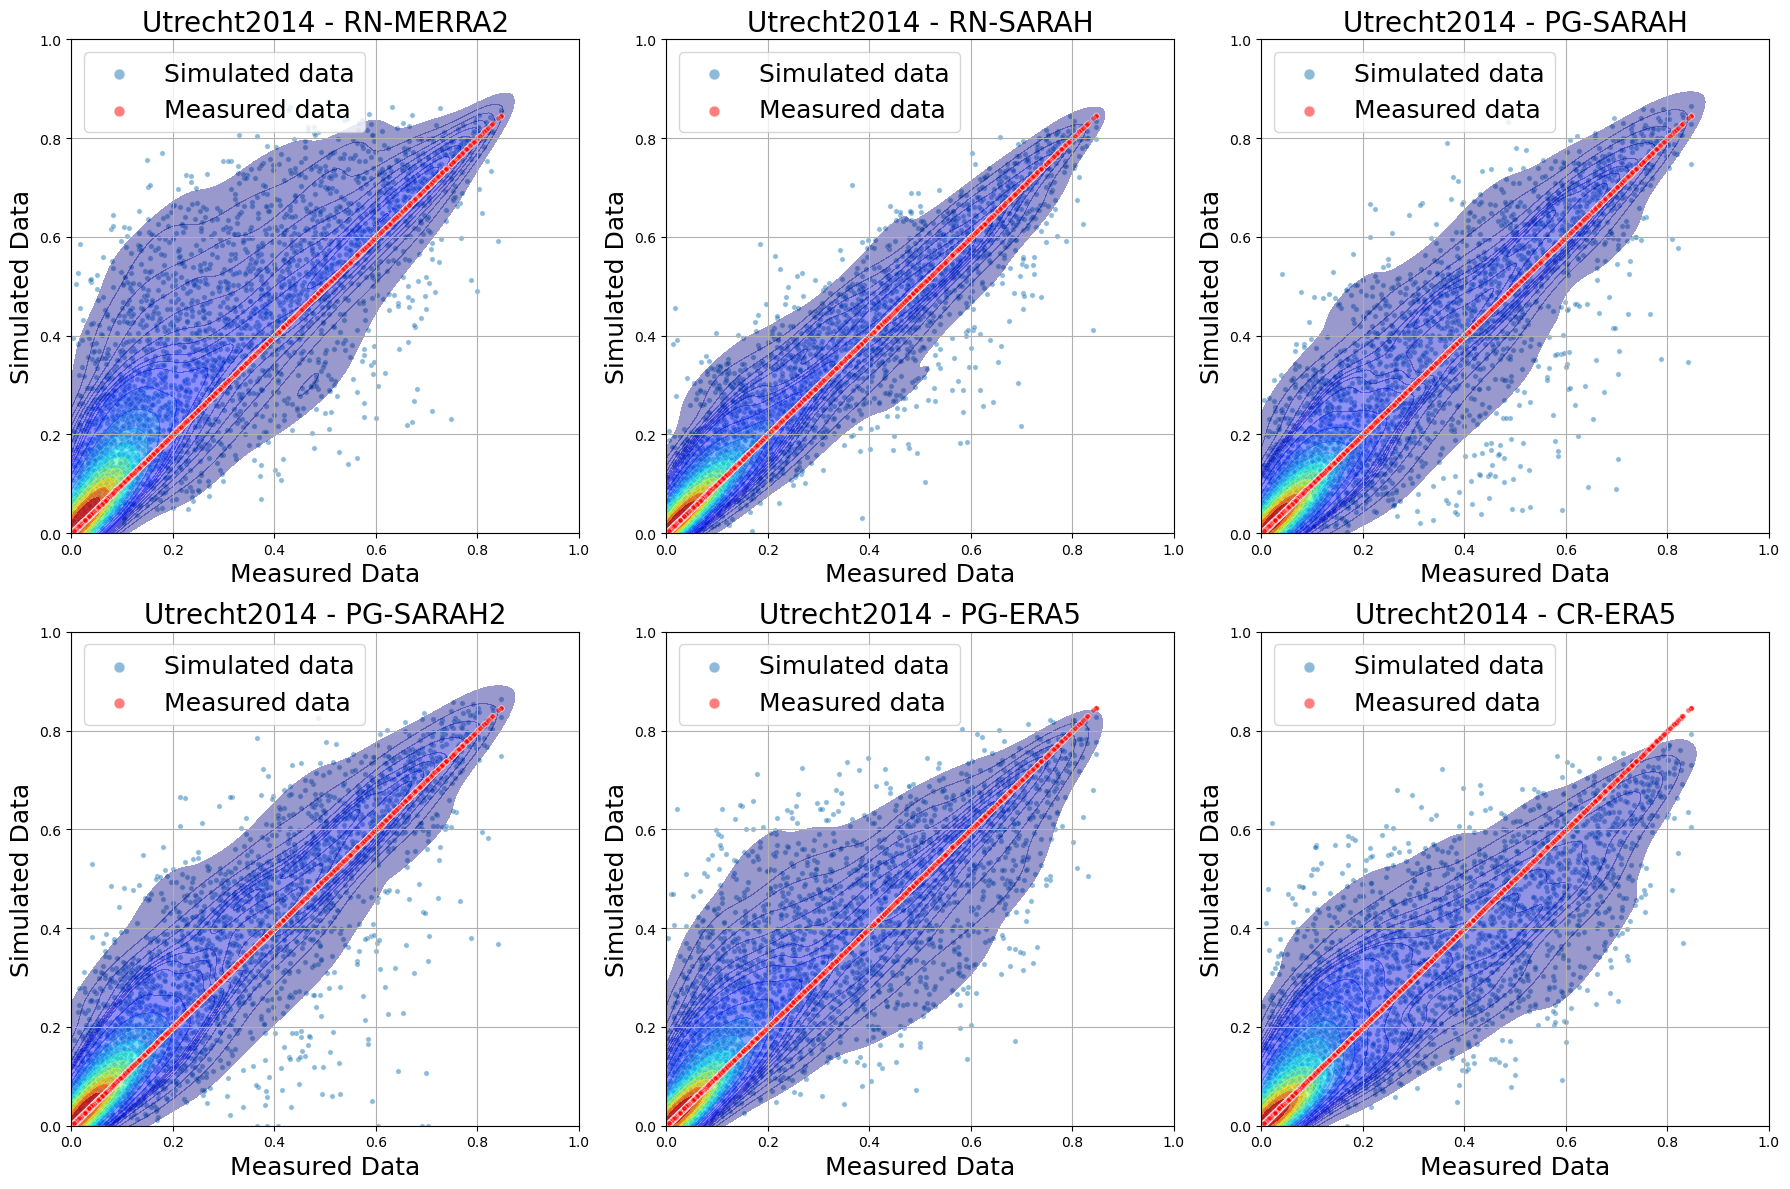

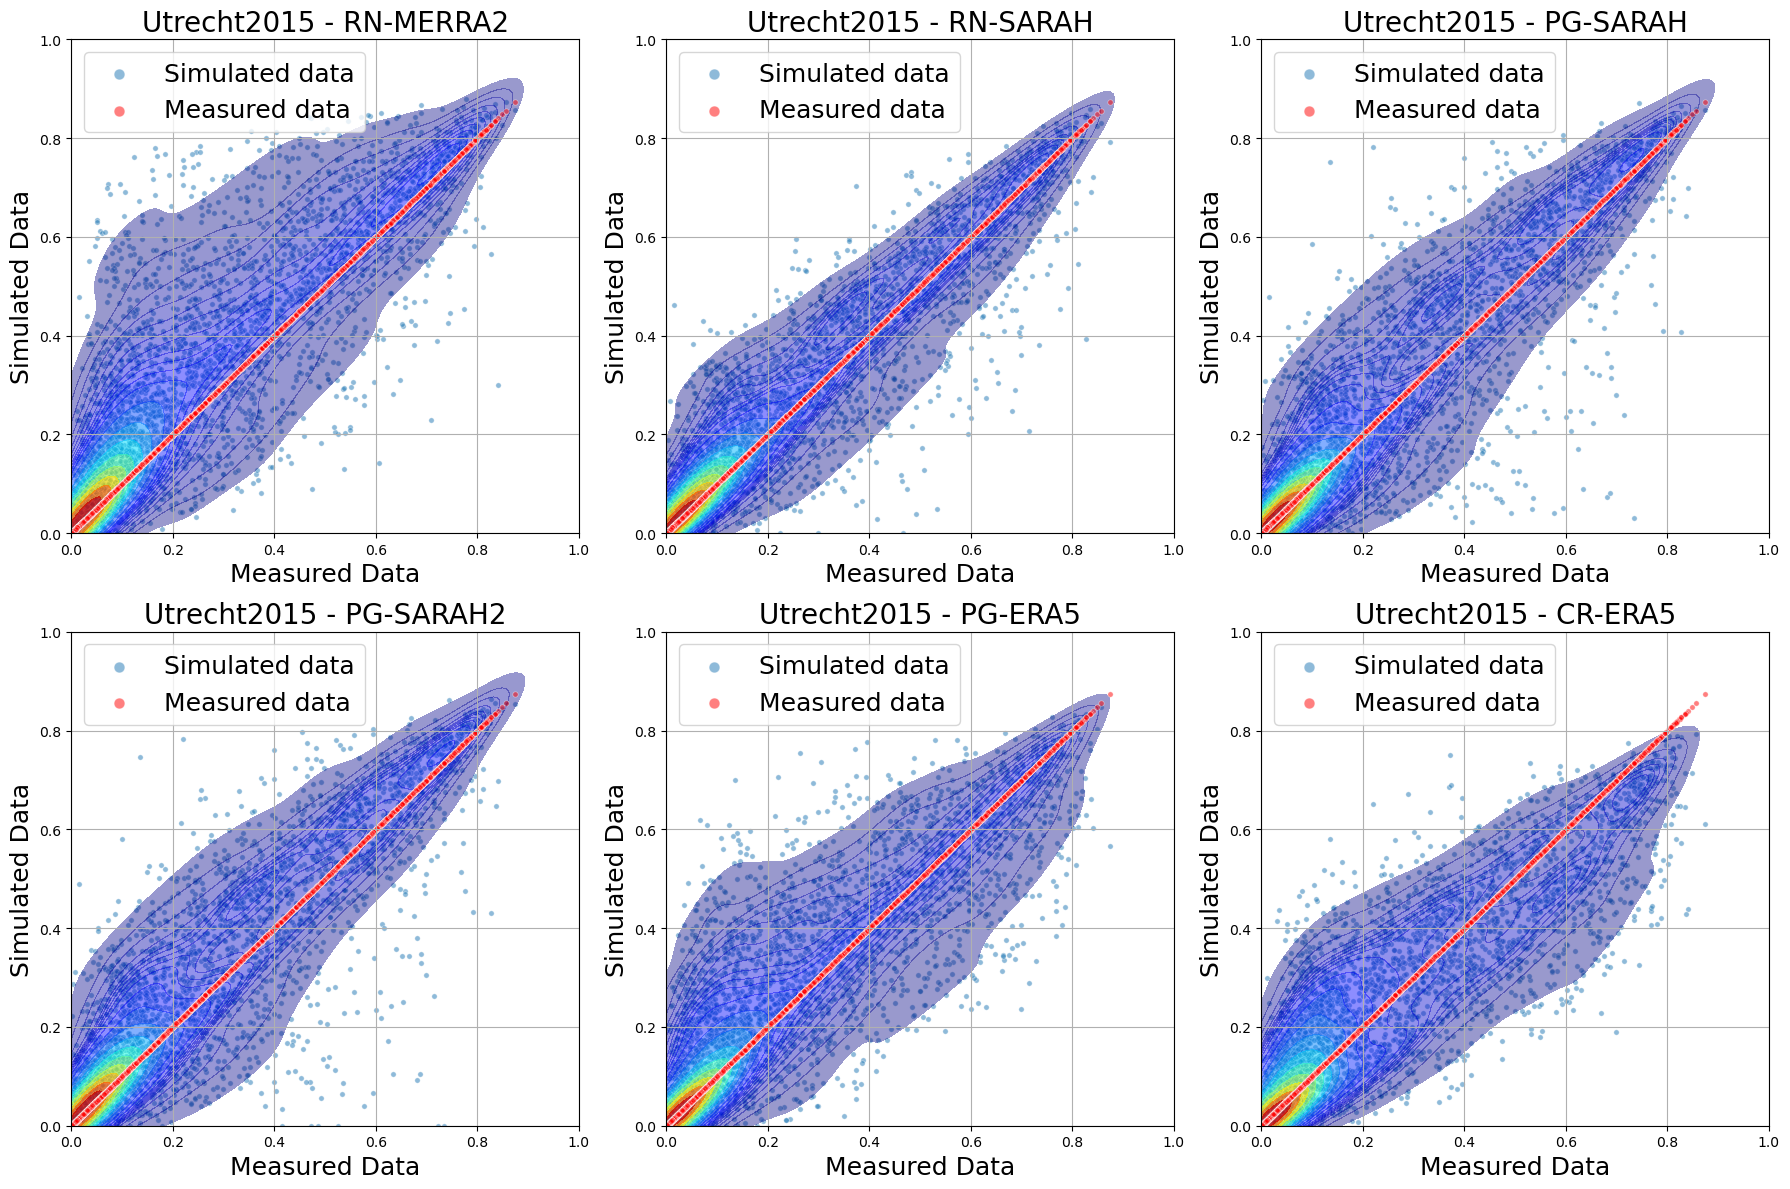

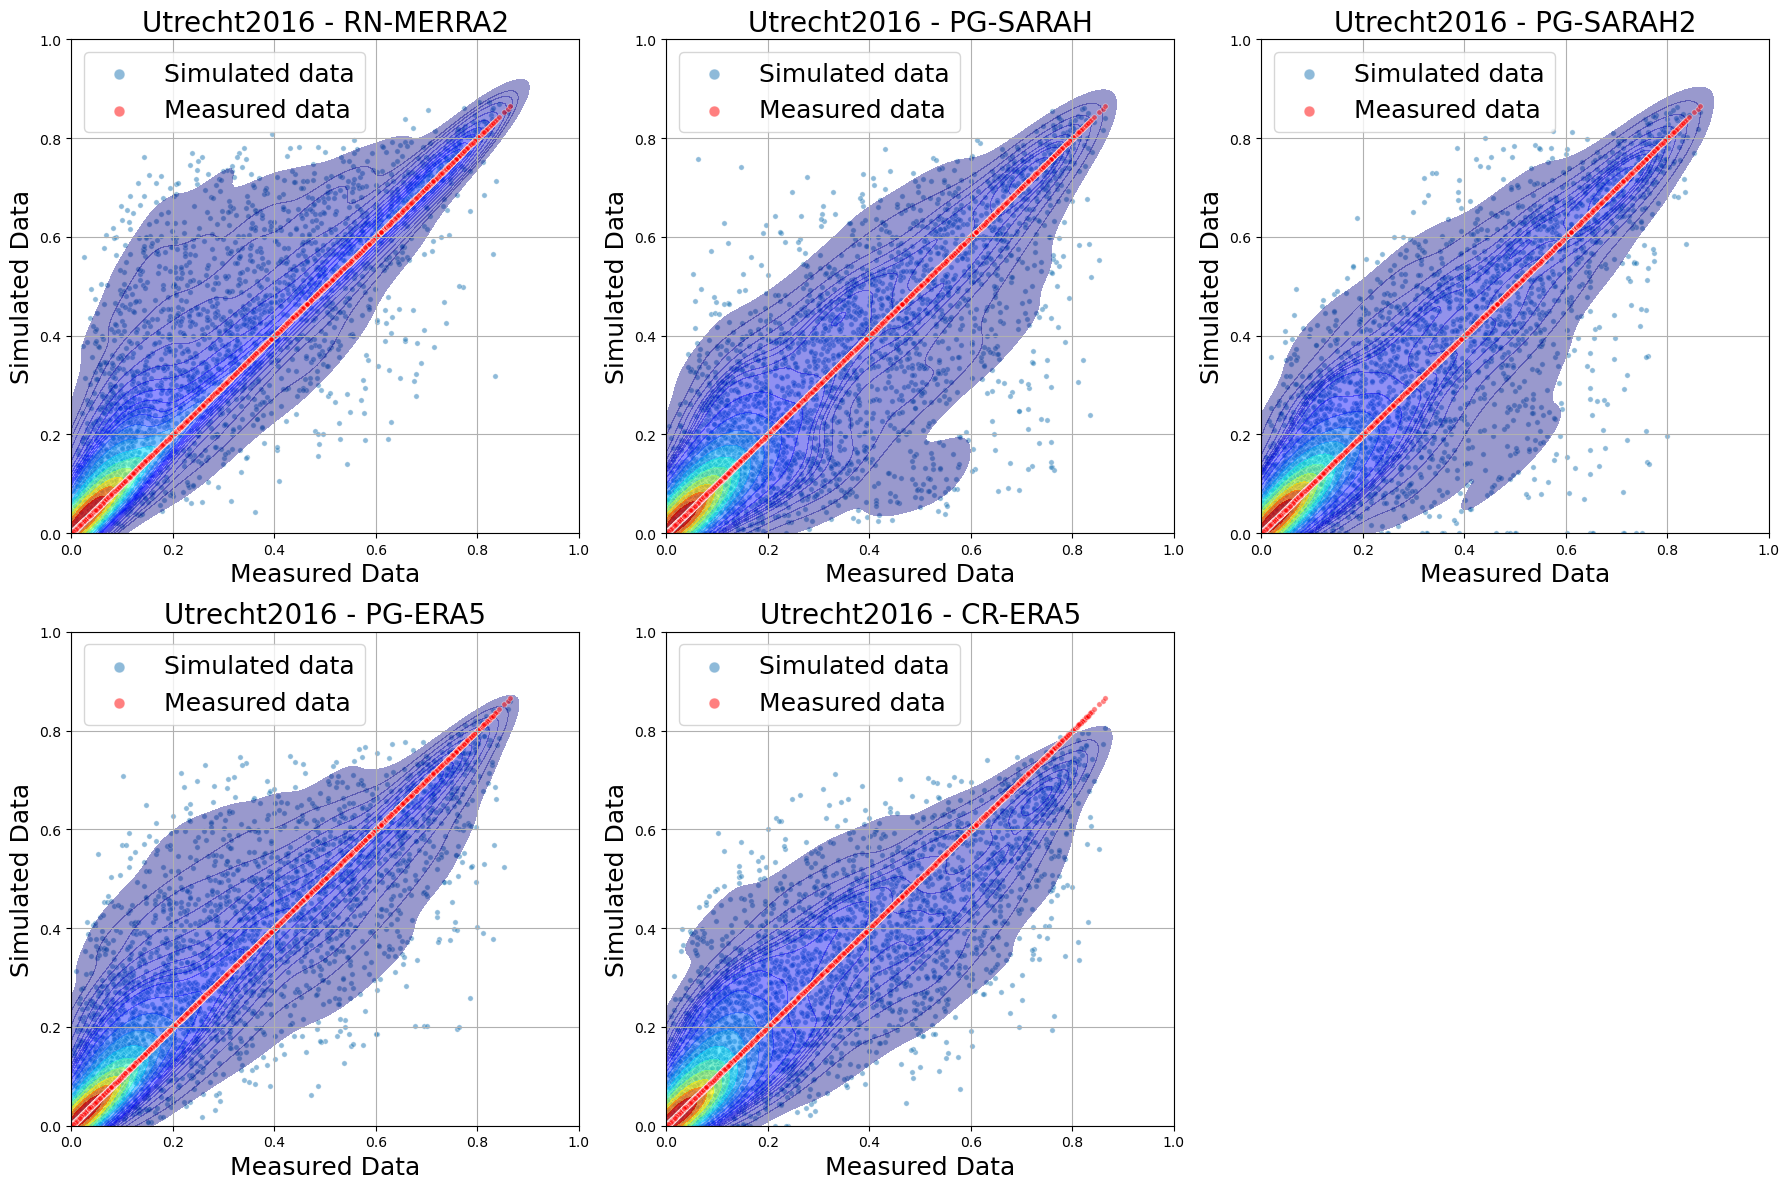

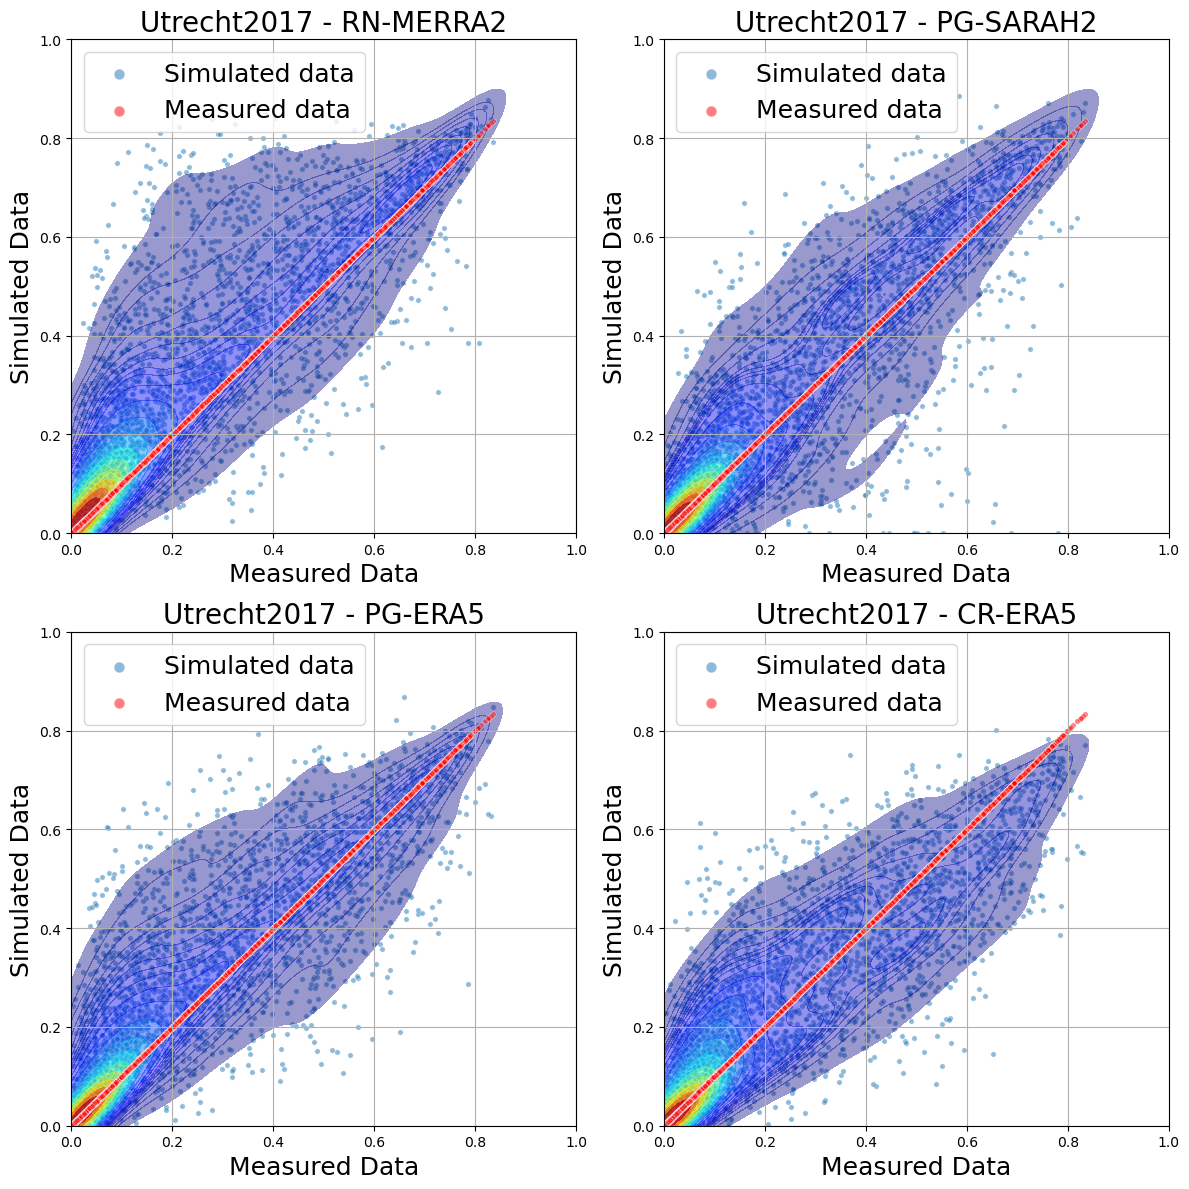

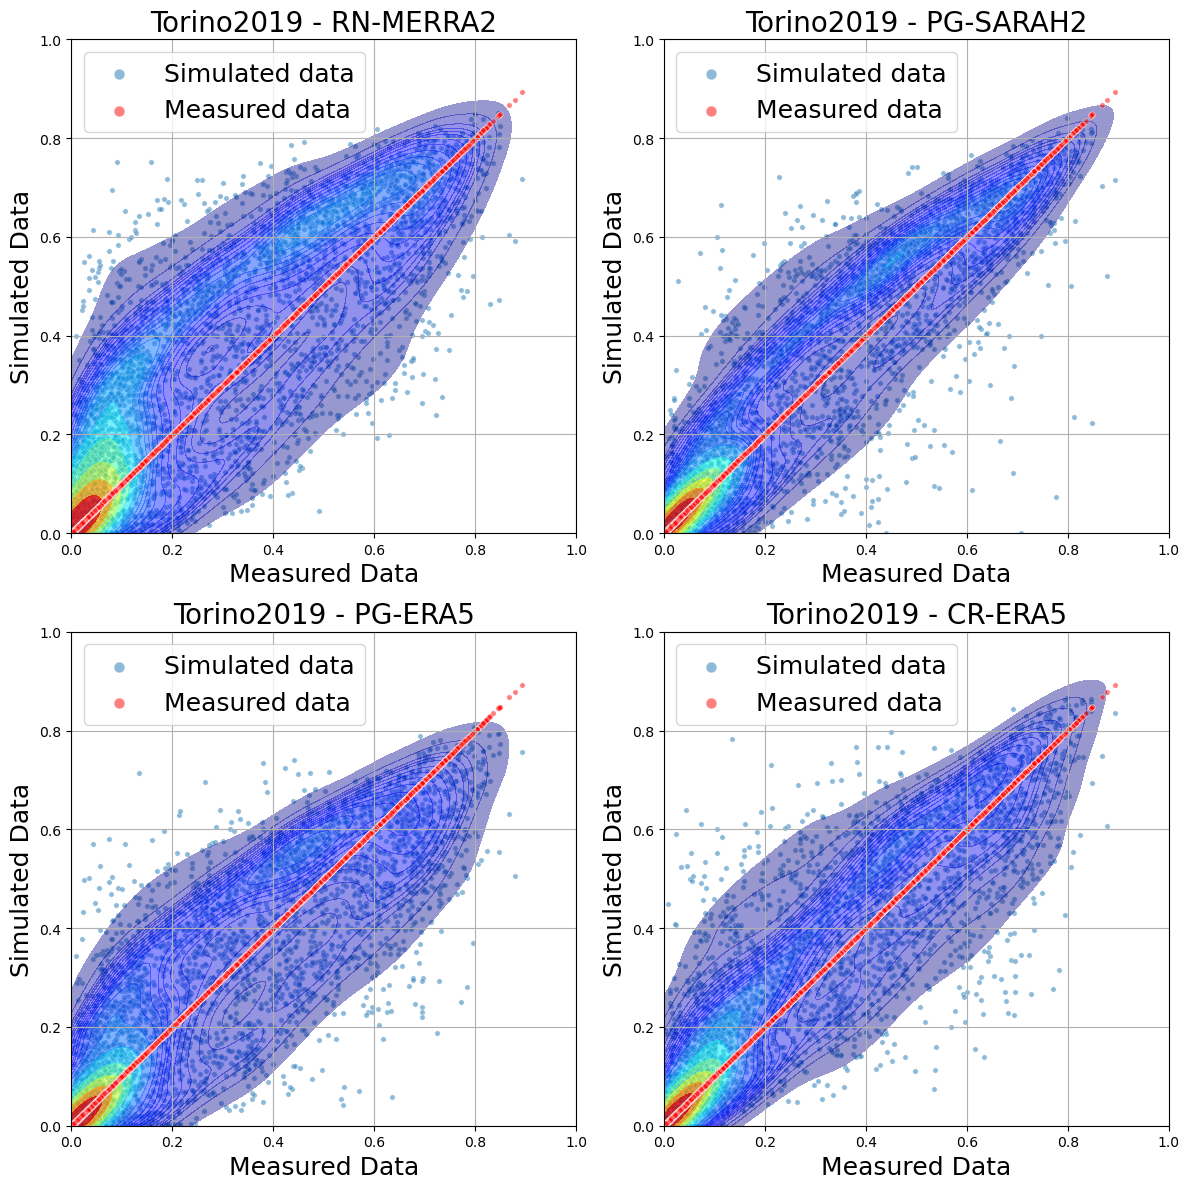

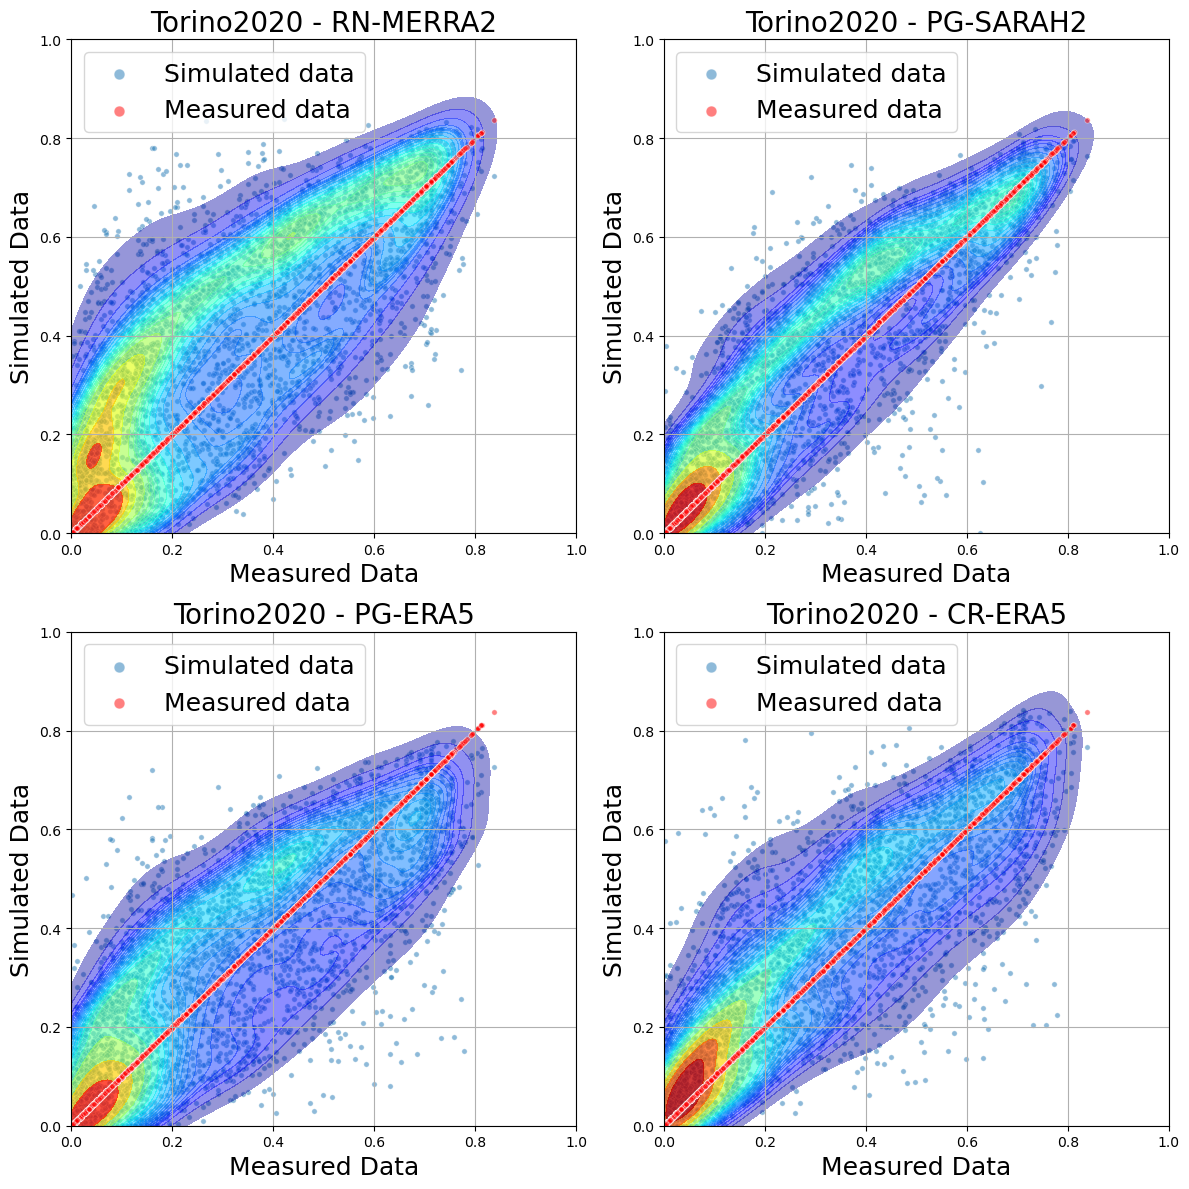

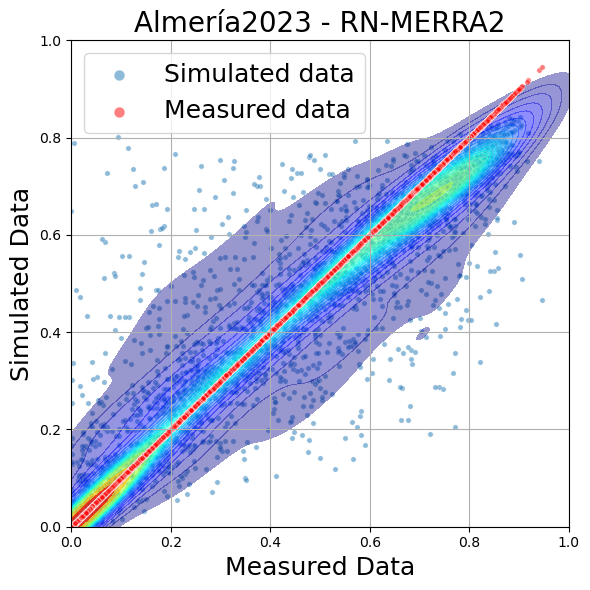

In [29]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import math
from matplotlib.colors import LinearSegmentedColormap

# Load data from the Excel file without setting headers initially
file_path = 'PV_DATA_meas_sim.xlsx'
data = pd.read_excel(file_path, header=None).iloc[:, 1:]  # Skip the first column and load without headers

# Drop the specific rows: original rows 0, 3, and 4
data.drop(index=[0, 3, 4], inplace=True)

# Reset index to realign row numbers after dropping rows
data.reset_index(drop=True, inplace=True)

# Set the new headers using what are now the first two rows (formerly rows 1 and 2 from the original data)
new_headers = data.iloc[0:2]  # These rows will be the new headers
data = data[2:]  # Remove these header rows from the data
data.columns = pd.MultiIndex.from_tuples(tuple(zip(new_headers.iloc[0], new_headers.iloc[1])))

# Combine the headers (location and tool) to form a unique column identifier
data.columns = [' '.join(col).strip() for col in data.columns.values]

# Identify unique locations from the first part of the column names
locations = []
for col in data.columns:
    location = col.split()[0]
    if location not in locations:
        locations.append(location)

# Create directory for saving graphs
output_dir = 'Graphs2'
os.makedirs(output_dir, exist_ok=True)

# Get the jet colormap
jet = plt.cm.jet
colors = jet(np.linspace(0, 1, 256))
for i in range(colors.shape[0]):
    colors[i, -1] = np.linspace(0.4, 0.8, 256)[i]  # Adjust transparency
custom_cmap = LinearSegmentedColormap.from_list('jet_custom', colors)

for location in locations:
    # Filter data for the current location
    loc_data = data[[col for col in data.columns if col.startswith(location)]]
    filtered_data = loc_data[loc_data[loc_data.columns[0]] != 0]  # Assuming first column as 'PV-MEAS'

    # Further filter to exclude any columns with all zeros except the first column
    valid_columns = [loc_data.columns[0]] + [col for col in loc_data.columns[1:] if not loc_data[col].eq(0).all()]
    filtered_data = filtered_data[valid_columns]

    real_data = filtered_data[filtered_data.columns[0]]  # 'PV-MEAS' data

    # Number of plots adjusted for valid simulation tools only
    num_plots = len(filtered_data.columns) - 1
    if num_plots == 0:
        continue  # Skip to next location if no valid data to plot

    cols = int(math.ceil(math.sqrt(num_plots)))
    rows = int(math.ceil(num_plots / cols))

    fig, axs = plt.subplots(rows, cols, figsize=(cols*6, rows*6))
    axs = axs.flatten() if num_plots > 1 else [axs]  # Handle single subplot case

    for idx, sim_col in enumerate(filtered_data.columns[1:]):
        ax = axs[idx]
        simulated_data = filtered_data[sim_col]

        sns.scatterplot(x=real_data, y=simulated_data, alpha=0.5, edgecolor='w', linewidth=0.5, label='Simulated data', s=15, ax=ax)
        sns.kdeplot(x=real_data, y=simulated_data, fill=True, cmap=custom_cmap, levels=20, ax=ax)
        sns.scatterplot(x=real_data, y=real_data, alpha=0.5, edgecolor='w', color='r', linewidth=0.5, label='Measured data', s=15, ax=ax)

        ax.set_title(f"{location} - {sim_col.split()[1]}", fontsize=20)
        ax.set_xlabel('Measured Data', fontsize=18)
        ax.set_ylabel('Simulated Data', fontsize=18)
        ax.grid(True)
        ax.set_xlim(0, 1)
        ax.set_ylim(0, 1)
        ax.legend(scatterpoints=1, markerscale=2, fontsize=18, loc='upper left')

    # Adjust for any extra axes
    for j in range(idx + 1, len(axs)):
        fig.delaxes(axs[j])

    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, f'{location}_simulation_data.png'))
    plt.show()
    plt.close(fig)  # Close the figure to free up memory
